In [1]:
#Imports.

import matplotlib.pyplot as plt
import numpy as np
import os.path
import refnx, scipy
from refnx.analysis import CurveFitter, Objective, Parameter, GlobalObjective, process_chain
from refnx.reflect import SLD, ReflectModel, Structure, LipidLeaflet
from refnx.dataset import ReflectDataset
import random
import tqdm

np.random.seed(1234)
%matplotlib inline

In [2]:
#Load in data. 

data_d2o = ReflectDataset('54696_97_d2o.txt')
data_pmw = ReflectDataset('54699_00_pmw.txt')

#Materials (Scattering Length Density)

d2o_sld = Parameter(6.07, 'd2o SLD', vary=True, bounds= (6,6.35))
pmw_sld = Parameter(2.3, 'pmw SLD', vary=True, bounds= (2,3))

d2o = SLD(d2o_sld) #D2O
pmw = SLD(pmw_sld) #PMW
air = SLD(0) #Air


In [3]:
#Define all the neutron b's
bc = 0.6646e-4;	
bo = 0.5804e-4;	
bh = -0.3739e-4;
bp = 0.513e-4
bn = 0.936e-4
bd = 0.6671e-4

#Formulae of the molecule sections
CH2 = (1*bc) + (2*bh);
CH = (1*bc) + (1*bh);
CH3 = (1*bc) + (3*bh);
D2O = (2*bd) + (1*bo);
H2O = (2*bh) + (1*bo);

#Bilayer

sum_b_tails = (28*CH2) + (2*CH) + (2*CH3) 
sum_popc_heads = (8*bo) + (1*bp) + (1*bn) + (2*bc) + (4*CH2) + (3*CH3) + (1*CH)
sum_popg_heads = (10*bo) + (1*bp) + (2*bc) + (4*CH2) + (2*CH) + (2*bh)
sum_b_heads = (1/4)*(3*(sum_popc_heads) + (sum_popg_heads)) 

vCH2 = 27.7
nCH2 = 30
vCH3 = 54.6
volume_tails = (nCH2 * vCH2) + (2 * vCH3)
volume_heads = 331

#Monolayer

sum_m_tails = (34*CH2) + (2*CH3)
sum_m_heads = (1*bn) + (2*CH3)

volume_m_tails = vCH2*36
volume_m_heads = 54.6


In [4]:
#Priors

b_heads = Parameter(sum_b_heads, 'b_heads')
b_tails = Parameter(sum_b_tails, 'b_tails')

v_heads = Parameter(volume_heads, 'v_heads')
v_tails = Parameter(volume_tails, 'v_tails')

head_thickness = Parameter(14.9982, 'head thickness bilayer', vary = True, bounds = (6, 17))
tail_thickness = Parameter(18.6766, 'tail thickness bilayer', vary = True, bounds = (15, 20))

apm = Parameter(57.3779, 'apm bilayer', vary = True, bounds = (55, 62))
roughness = Parameter(3.30022, 'rough bilayer', vary = True, bounds = (3.3, 10))
solv_rough = Parameter(4, 'solv rough', vary = True, bounds = (3.3,10))

#Bilayer

bilayer_top = LipidLeaflet(apm,
                             b_heads, v_heads, head_thickness,
                             b_tails, v_tails, tail_thickness,
                             roughness, solv_rough, head_solvent = d2o)

bilayer_bottom = LipidLeaflet(apm,
                             b_heads, v_heads, head_thickness,
                             b_tails, v_tails, tail_thickness, 
                             roughness, solv_rough, head_solvent = d2o, reverse_monolayer=True)

bilayer_topPMW = LipidLeaflet(apm,
                             b_heads, v_heads, head_thickness,
                             b_tails, v_tails, tail_thickness,
                             roughness, solv_rough, head_solvent = pmw)

bilayer_bottomPMW = LipidLeaflet(apm,
                             b_heads, v_heads, head_thickness,
                             b_tails, v_tails, tail_thickness, 
                             roughness, solv_rough, head_solvent = pmw, reverse_monolayer=True)


#D2O slab
d2o_low = d2o(0, solv_rough)
d2o_slab = d2o(5, solv_rough)
d2o_slab.thick.setp(bounds=(5, 10), vary=True)

#PMW slab
pmw_low = pmw(0, solv_rough)
pmw_slab = pmw(5, solv_rough)
pmw_slab.thick.setp(bounds=(2, 10), vary=True)


In [5]:
#Monolayer construct

#Sum of scattering lengths for the lipid head and tail in Angstrom.

b_headsM = Parameter(sum_m_heads, 'mono b_heads')
b_tailsM = Parameter(sum_m_tails, 'mono b_tails')

#Volume occupied by the head and tail groups in cubic Angstrom.

v_headsM = Parameter(volume_m_heads, 'mono v_heads')
v_tailsM = Parameter(volume_m_tails, 'mono v_tails')

mHeadThick = Parameter(5, 'mono head_thickness', vary=True, bounds=(7, 20))
mTailThick = Parameter(20, 'mono tail_thickness', vary=True, bounds=(15, 30))

apmMono = Parameter(67.7, 'area per molecule monolayer', vary=False, bounds=(65, 75))
roughnessM = Parameter(4, 'roughness monolayer', vary=True, bounds=(3.3, 5))


#Construct monolayer

monolayerD2O = LipidLeaflet(apmMono,
                             b_headsM, v_headsM, mHeadThick,
                             b_tailsM, v_tailsM, mTailThick, 
                             roughnessM, solv_rough, head_solvent = d2o, reverse_monolayer=True)

monolayerPMW = LipidLeaflet(apmMono,
                             b_headsM, v_headsM, mHeadThick,
                             b_tailsM, v_tailsM, mTailThick, 
                             roughnessM, solv_rough, head_solvent = pmw, reverse_monolayer=True)


In [6]:
#Bilayer in D2O
struct_d2o = air | monolayerD2O | d2o_slab | bilayer_top | bilayer_bottom | d2o_low

#Bilayer in PMW
struct_pmw = air | monolayerPMW | pmw_slab | bilayer_topPMW | bilayer_bottomPMW | pmw_low

scaleargs = dict(value = 0.7675, vary=False, bounds=(0.5, 1))
bkgargs = dict(value = 2e-6, vary=True, bounds=(1e-6, 5e-6))

model_d2o = ReflectModel(struct_d2o)
model_d2o.scale.setp(**scaleargs)
model_d2o.bkg.setp(**bkgargs)

model_pmw = ReflectModel(struct_pmw)
model_pmw.scale.setp(**scaleargs)
model_pmw.bkg.setp(**bkgargs)

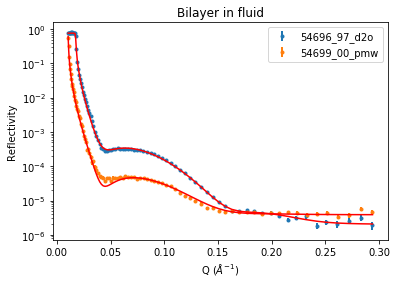

In [7]:
obj_d2o = Objective(model_d2o, data_d2o)
obj_pmw = Objective(model_pmw, data_pmw)
global_obj = GlobalObjective([obj_d2o, obj_pmw])

fitter = CurveFitter(global_obj)
fitter.fit('differential_evolution')

global_obj.plot()
plt.title('Bilayer in fluid')
plt.yscale('log')
plt.xlabel('Q $(\AA^{-1})$')
plt.ylabel('Reflectivity')
plt.legend();

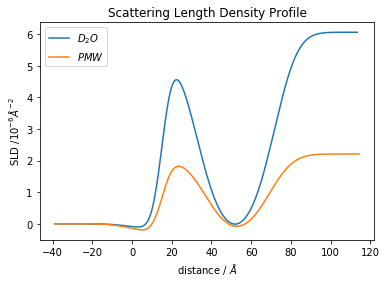

In [8]:
#SLD profile of structure.

plt.plot(*struct_d2o.sld_profile(), label = '$D_2O$')
plt.plot(*struct_pmw.sld_profile(), label = '$PMW$')
plt.title('Scattering Length Density Profile')
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
plt.legend()
plt.savefig('SLDProfile.png');

In [9]:
print(global_obj.parameters)

________________________________________________________________________________
Parameters: 'global fitting parameters'
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=0.7675 (fixed)  , bounds=[0.5, 1]>
<Parameter:     'bkg'     , value=1.96032e-06 +/- 2.62e-07, bounds=[1e-06, 5e-06]>
<Parameter:'dq - resolution', value=5 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:   ' - sld'    , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:   ' - isld'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  

In [10]:
#Burn frist 200, sample every 10th from 1000.

fitter.sample(1000)
process_chain(global_obj, fitter.chain, nburn=200, nthin=10, flatchain=True);

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/Miron/miniconda3/envs/refnx/lib/python3.7/site-packages/refnx/_lib/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [11:43<00:00,  1.42it/s]


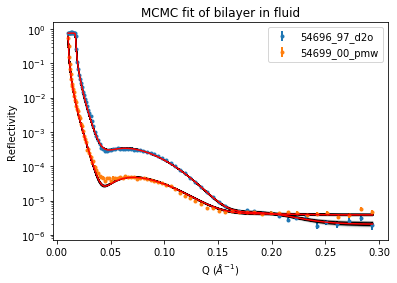

In [11]:
global_obj.plot(samples = 500)
plt.title('MCMC fit of bilayer in fluid')
plt.yscale('log')
plt.xlabel('Q $(\AA^{-1})$')
plt.ylabel('Reflectivity')
plt.legend();

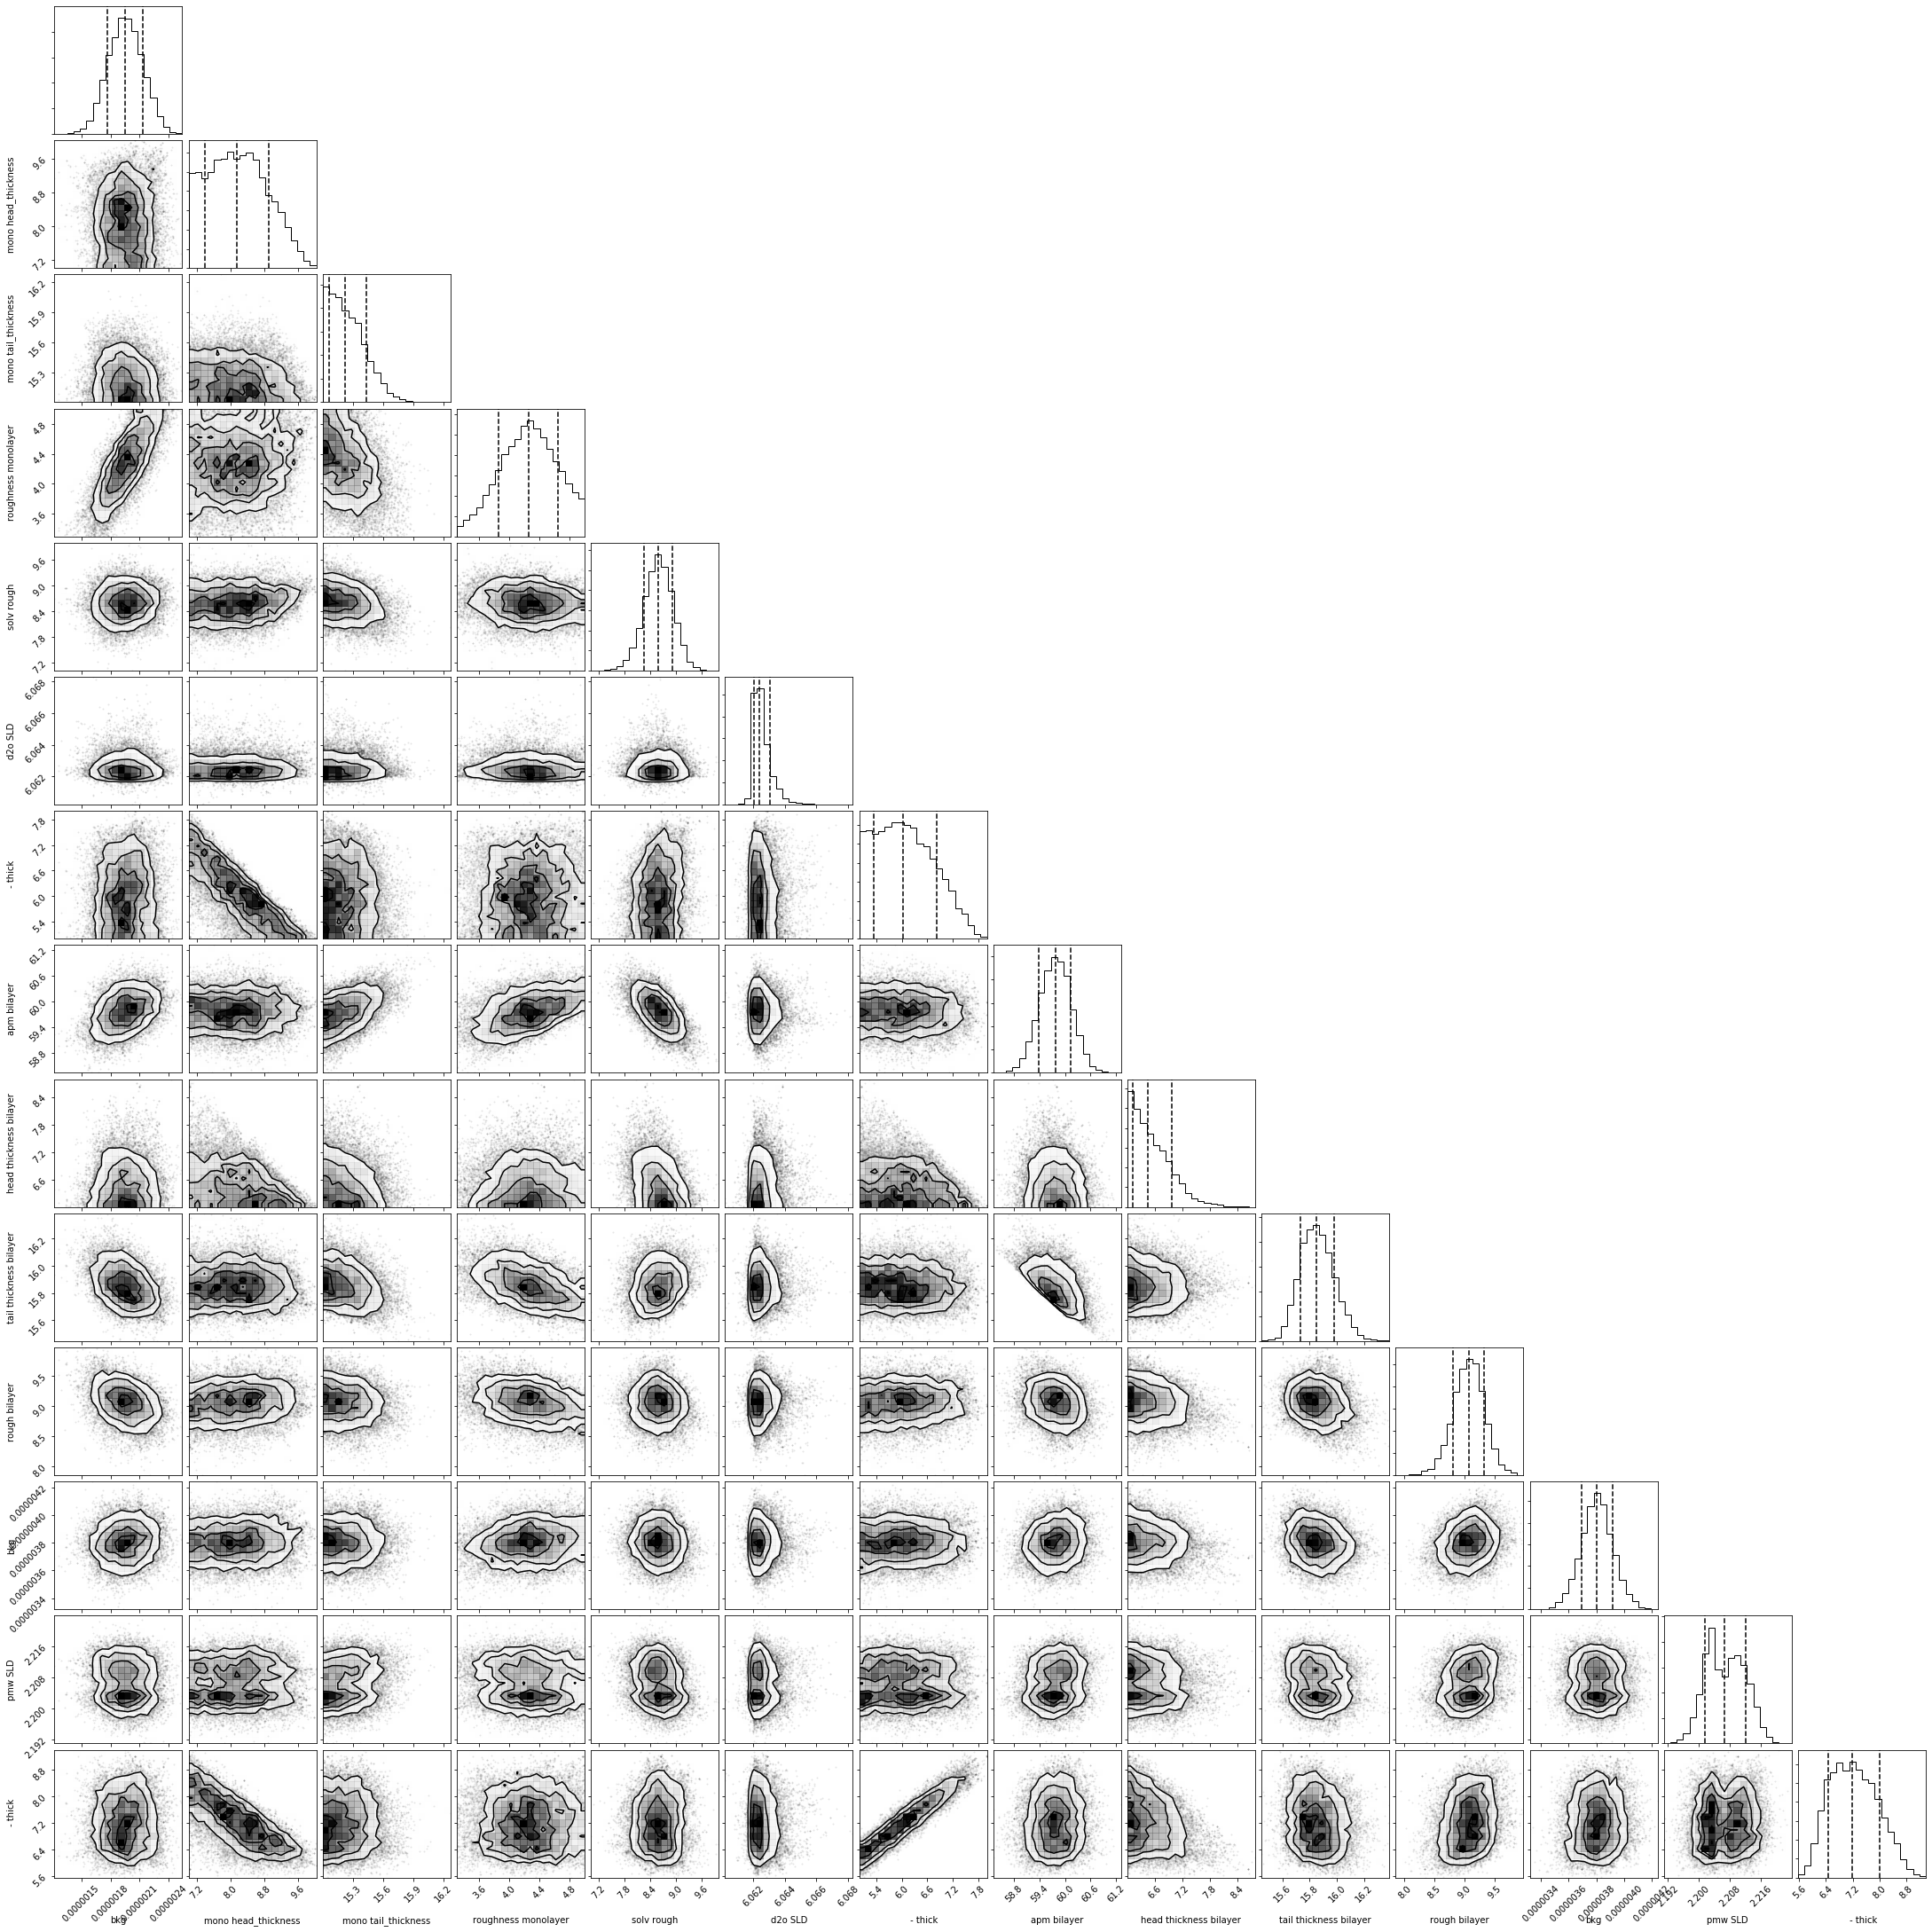

In [12]:
global_obj.corner()
plt.savefig('cornerMono.png');

In [13]:
print(global_obj.parameters);

________________________________________________________________________________
Parameters: 'global fitting parameters'
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=0.7675 (fixed)  , bounds=[0.5, 1]>
<Parameter:     'bkg'     , value=1.95063e-06 +/- 1.82e-07, bounds=[1e-06, 5e-06]>
<Parameter:'dq - resolution', value=5 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:   ' - sld'    , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:   ' - isld'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  

In [14]:
headThick = head_thickness.value
tailThick = tail_thickness.value

frac = 1 - ((tailThick*v_heads.value)/(v_tails.value*headThick))
Water = (frac*v_heads.value)/(29.9*(1 - frac))

print('Solvent fraction: {:.5f}\nWaters per head: {:.0f}'.format(frac, Water))

Solvent fraction: 0.13525
Waters per head: 2
